# Imports

In [61]:
import os
from platypus import NSGAII, Problem, Real, nondominated_sort, SBX, PM, GAOperator, Evaluator, run_job
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import path
from shapely.geometry import Polygon, shape, Point
from descartes import PolygonPatch
import pylab as pl
from shapely import affinity
import random
import copy
from joblib import Parallel, delayed
import multiprocessing

In [62]:
max_cores = multiprocessing.cpu_count()
print(max_cores)

12


In [63]:
os.chdir('C:/Users/zacha/Documents/GitHub/plymouth-university-proj518/data')
print(os.getcwd())

C:\Users\zacha\Documents\GitHub\plymouth-university-proj518\data


# OWF Problem

In [73]:
class OWF(Problem):
    def __init__(self, lon_limits, lat_limits, day_limits, data, map_polygon, wrecks_and_obstructions, shipping_density):
        """Locate optimal location (lat and long) in an area, to maximise
        Nvars: 11 (rotation of shape, lat/long center coordinates, 4 sets of lat/long offsets from center to define corners)
        """
        super(OWF, self).__init__(11, 5, 2)

        self.lat_limits = lat_limits
        self.lon_limits = lon_limits
        self.day_limits = day_limits

        self.data = data
        self.map_polygon = map_polygon
        self.wrecks_and_obstructions = wrecks_and_obstructions
        self.shipping_density = shipping_density

        #lat_range = lat_limits[1] - lat_limits[0]
        #lon_range = lon_limits[1] - lon_limits[0]

        # experimentally defined site size limitations
        lat_range = lon_range = 0.007201325686340829
        #lon_range = 5.203365643890723e-07

        # only predict locations within the site boundaries
        # allow predictions to be Real numbers (i.e. floats)
        self.types = [
            # polygon is rotated by rotation angle
            Real(0, 360),

            # center of site
            Real(self.lon_limits[0], self.lon_limits[1]),  # center lat
            Real(self.lat_limits[0], self.lat_limits[1]),  # center lon

            # corners are offset from center coordinates

            Real(-lon_range, 0),    # q1 lon
            Real(0, lat_range),     # q1 lat
            
            Real(0, lon_range),     # q2 lon
            Real(0, lat_range),     # q2 lat

            Real(0, lon_range),     # q3 lon
            Real(-lat_range, 0),    # q3 lat

            Real(-lon_range, 0),    # q4 lon
            Real(-lat_range, 0),    # q4 lat
        ]

        self.directions = [
            Problem.MAXIMIZE,   # maximise Velocity Potential
            Problem.MINIMIZE,   # minimise area used
            Problem.MINIMIZE,   # minimise differential of mean velocity potential across days
            Problem.MINIMIZE,   # minimise shipping density at solution
            Problem.MINIMIZE,   # minimise wrecks and obstructions within solution
        ]

        self.constraints[:] = [
           "==100",  # constrain valid shapes to have >98% intersection with site boundary
           #"<0.8",    # constrain area of sites to be less than 0.8 (experimentally defined)
           ">-40",   # contrain depth of site to max. 40m (invert bc depth goes -inf -> 0)
           #">80",      # constrain proximity to avoid other solutions
        ]

    def evaluate(self, solution):
        """Evaluate variables of solution to determine fitness.

        Solution variables contain the following:
            rotation: rotation of the polygon about the center point.

            center_lat: latitude of the center point.
            center_lon: longitude of the center point.

            q1_lat: latitude of the first point of the quadrilateral.
            q1_lon: longitude of the first point of the quadrilateral.
            q2_lat: latitude of the second point of the quadrilateral.
            q2_lon: longitude of the second point of the quadrilateral.
            q3_lat: latitude of the third point of the quadrilateral.
            q3_lon: longitude of the third point of the quadrilateral.
            q4_lat: latitude of the fourth point of the quadrilateral.
            q4_lon: longitude of the fourth point of the quadrilateral.
        """

        x = solution.variables[:]

        # read solution into variables
        rotation = x[0]
        center = x[1:3]
        q1, q2, q3, q4 = x[3:5], x[5:7], x[7:9], x[9:11]
        
        # calculate corner coordinates from center and q offset
        q1_coord = [center[0] + q1[0], center[1] + q1[1]]
        q2_coord = [center[0] + q2[0], center[1] + q2[1]]
        q3_coord = [center[0] + q3[0], center[1] + q3[1]]
        q4_coord = [center[0] + q4[0], center[1] + q4[1]]

        # rotation corner coordinates by rotation angle
        points = np.array([q1_coord, q2_coord, q3_coord, q4_coord])
        polygon = path.Path(points)

        # get bathymetryic and velocity potential data within polygon
        data_polygon = self.data[
            polygon.contains_points(self.data[["Lon", "Lat"]].values)
        ]

        # dataframe is empty, because no data at that location (out of bounds / too small)
        if data_polygon.empty:
            # make fitness infinitely bad
            area = np.inf
            depth = -np.inf
            velocity_potential = -np.inf
            velocity_potential_stability = np.inf
            shipping_density = np.inf
            wrecks_and_obstructions = np.inf
            intersection = -np.inf

        else:
            # get all wrecks and obstructions within polygon
            wrecks_and_obstructions = self.wrecks_and_obstructions[
                polygon.contains_points(self.wrecks_and_obstructions[["longitude", "latitude"]].values)
            ]
            # fitness is number of wrecks or obstructions inside polygon (less is better)
            wrecks_and_obstructions = len(wrecks_and_obstructions)

            # get shipping density by locating density polygon which contains center point
            shipping_density = np.inf
            for i, row in self.shipping_density.iterrows():
                # test if center is within row['polygon']
                if row['polygon'].contains_point(center):
                    shipping_density = row['yearly_avg']
                    break

            # calculate mean Velocity Potential
            velocity_potential = data_polygon.drop(['Lon', 'Lat', 'Depth'], axis=1)
            velocity_potential_mean = velocity_potential.mean(axis=1)

            # calculate stability of polygon
            # calculate difference between mean velocity potential at each day
            velocity_potential_stability = abs(velocity_potential_mean.diff().mean())

            # get mean Velocity Potential across all days
            velocity_potential = velocity_potential_mean.mean()    # repeat .mean() to get single mean of 2D array
            
            # calculate intersection of polygon with map polygon
            shapely_polygon = Polygon(points).buffer(0)

            # rotate polygon by rotation angle about center coordinate
            shapely_polygon = affinity.rotate(shapely_polygon, rotation, origin=center)

            # calculate intersection area between map polygon and solution polygon
            intersection = self.map_polygon.intersection(shapely_polygon).area
            intersection = intersection / shapely_polygon.area * 100.0

            # scale area of polygon
            area = shapely_polygon.area * 100.0

            # get max depth from bathymetric data polygon
            # with contraints, ensure turbines can be placed in any section of area
            # NOTE: if problems finding solutions - revert to mean depth, ensuring dominant % of polygon is viable regarding depth
            depth = data_polygon["Depth"].max()

        solution.objectives[:] = [
            velocity_potential,
            area,
            velocity_potential_stability,
            shipping_density,
            wrecks_and_obstructions,
        ]
        
        solution.constraints[:] = [
            intersection,
            depth,
        ]


## Custom Variator

* The default SBX Variator applies crossover to all decision variables in the solution.
* As the decision variables of our solution are spatial, meaning solutions for one location may not apply well to another, crossover at a high rate only results in solution covergence in the search space.
* To reduce this, we experiment with reducing probability of crossover between solutions for all or specific decision variables.

In [65]:
class CustomSBX(SBX):
    def __init__(self):
        super(CustomSBX, self).__init__()
        self.probability1 = 1.0
        self.probability2 = 1.0

    def evolve(self, parents):
        child1 = copy.deepcopy(parents[0])
        child2 = copy.deepcopy(parents[1])
        
        if random.uniform(0.0, 1.0) <= self.probability1:
            problem = child1.problem
            nvars = problem.nvars
            
            for i in range(nvars):
                if i == 1 or i == 2:
                    continue    # skip crossover of center coordinates

                elif isinstance(problem.types[i], Real):
                    if random.uniform(0.0, 1.0) <= self.probability2:
                        x1 = float(child1.variables[i])
                        x2 = float(child2.variables[i])
                        lb = problem.types[i].min_value
                        ub = problem.types[i].max_value
                        
                        x1, x2 = self.sbx_crossover(x1, x2, lb, ub)
                        
                        child1.variables[i] = x1
                        child2.variables[i] = x2
                        child1.evaluated = False
                        child2.evaluated = False
                    
        return [child1, child2]

## Multiprocessing evaluator

* Solutions can be evaluated independently, enabling parallelization on multi-core processors.
* By splitting computationally intensive task amongst cores, speed-up can be achieved.
* We augmented the MapEvaluator function (default evaluator applied to solutions) with multiprocessing to achieve this.

In [66]:
class MultiprocessingMapEvaluator(Evaluator):
    
    def __init__(self, num_cores, map_func=map):
        super(MultiprocessingMapEvaluator, self).__init__()
        self.map_func = map_func
        self.num_cores = num_cores

    def _chunks(self, items, n):
        result = []
        iterator = iter(items)
        
        try:
            while True:
                result.append(next(iterator))
                
                if len(result) == n:
                    yield result
                    result = []
        except StopIteration:
            if len(result) > 0:
                yield result
    
    def evaluate_job(self, chunk):
        return self.map_func(run_job, chunk)
    
    def evaluate_all(self, jobs, **kwargs):
        log_frequency = kwargs.get("log_frequency", None)
        
        if log_frequency is None:
            results = Parallel(n_jobs=self.num_cores)(delayed(run_job)(job) for job in jobs)

        else:
            results = Parallel(n_jobs=self.num_cores)(delayed(self.evaluate_job)(chunk) for chunk in self._chunks(jobs, log_frequency))

        return results

# Data

## Uk east coast velocity potential and bathymetry data

In [67]:
data = pd.read_csv("UK east coast velocity potential bathymetry.csv")

# NOTE: experimentally defined, enclosing area of map with depth >40m
lat_range = (53.486257927, 54.1)
lon_range = (0.5, 2.5571098)
days_range = (0, 288)

print(f"Latitude range: {lat_range}, Longitude range: {lon_range}")

print(data.head())

Latitude range: (53.486257927, 54.1), Longitude range: (0.5, 2.5571098)
        Lon        Lat          0          1          2          3          4  \
0  0.908810  53.508833 -4888854.5 -2964274.8 -1966400.0 -1944809.2 -322963.75   
1  0.982291  53.615490 -4988734.5 -3007930.2 -2047237.6 -2029393.5 -354367.40   
2  0.827796  53.586244 -4784387.0 -2952906.5 -1962346.2 -1973532.0 -356079.72   
3  0.837720  53.702704 -4801098.0 -2978041.2 -2017788.0 -2047978.2 -395331.00   
4  1.000396  53.708305 -5014005.5 -3031230.2 -2096183.8 -2092127.0 -384673.72   

           5          6          7  ...        220        221        222  \
0  1918140.2  2201700.2  497169.94  ...  3623697.0  3458370.5  3322026.8   
1  1893077.1  2230719.8  457650.47  ...  3645998.0  3475556.8  3341163.8   
2  1899125.8  2204834.5  470712.70  ...  3644461.0  3473458.5  3349537.8   
3  1871085.8  2224391.5  432494.90  ...  3669871.5  3497450.5  3374911.8   
4  1869927.0  2249043.0  425658.60  ...  3665922.8  3491546.0

## UK east coast edge points alpha 17.5 data

In [68]:
# read map polygon coords and create polygon
polygon_df = pd.read_csv("UK east coast edge points alpha 17.5.csv")
polygon_np = polygon_df.to_numpy()

map_polygon = Polygon(polygon_np)


## UK east coast wrecks and obstructions

In [69]:
wrecks_and_obstructions = pd.read_csv("UK east coast wrecks and obstructions.csv")

## UK east coast shipping density (2015)

In [70]:
shipping_density = pd.read_csv("UK east coast shipping density 2015.csv")

shipping_density['polygon'] = shipping_density['polygon'].apply(lambda x: path.Path(eval(x)))

# Optimisation

In [74]:
# load the problem
problem = OWF(
    lat_limits=lat_range,
    lon_limits=lon_range,
    day_limits=days_range,
    data=data,
    map_polygon=map_polygon,
    wrecks_and_obstructions=wrecks_and_obstructions,
    shipping_density=shipping_density,
)

In [75]:
# run the optimisation using multiprocessing
with MultiprocessingMapEvaluator(num_cores=1) as evaluator:
    algorithm = NSGAII(problem, population_size=100, variator=GAOperator(CustomSBX(), PM()), evaluator=evaluator)
    algorithm.run(5000)

In [80]:
# get feasible and nondominated solutions
feasible_solutions = [s for s in algorithm.result if s.feasible]
print(f"Feasible solutions: {len(feasible_solutions)}")

nondominated_sort(feasible_solutions)   # rank feasible solutions

# convert results to pandas dataframe
results = pd.DataFrame(
    columns=[
        "Rank",
        "rotation",
        "center_lon",
        "center_lat",
        "q1_lon",
        "q1_lat",
        "q2_lon",
        "q2_lat",
        "q3_lon",
        "q3_lat",
        "q4_lon",
        "q4_lat",
        "Velocity Potential",
        "Area",
        "Stability",
        "Shipping Density",
        "Wrecks and Obstructions",
    ]
)

# read nondominated solutions into dataframe
for i, solution in enumerate(feasible_solutions):
    results.loc[i] = [solution.rank, *solution.variables[:], *solution.objectives]

print(f"Ranks: {len(set(results['Rank']))}, Nondominated: {len(results.loc[results['Rank'] == 0])}")


Feasible solutions: 100
Ranks: 1, Nondominated: 100


# Visualisation


## Pareto front

### 5-D nondominated front visualisation

In [100]:
def multidimensional(r):
    # Visualizing 5-D mix data using bubble charts
    # leveraging the concepts of hue, size and depth
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    t = fig.suptitle('Velocity potential - Stability - Area - Shipping density - Wrecks and obstructions')

    # calculate min and max values for Area
    rmin, rmax = r['Area'].min(), r['Area'].max()
    # calculate step size for Area
    rdiff = rmax - rmin
    sizing = ((r['Area'] - rmin) / rdiff) * 100  # calculate size as a percentage of max size, then scale to become a useful size in the plot

    colormap = ax.scatter(r['Stability'], r['Shipping Density'], r['Wrecks and Obstructions'], alpha=0.4, c=r['Velocity Potential'], cmap='viridis', edgecolors='none', s=sizing)

    ax.set_xlabel('Stability (mean deviation of Velocity Potential/year)')
    ax.set_ylabel('Shipping Density (mean shipping activity/week)')
    ax.set_zlabel('Wrecks and Obstructions (total wrecks / obstructions in solution space)')

    fig.text(.5, .05, 'Area (size of point is relative area of solution)', ha='center')

    # add a legend indicating the depth of each point
    cbar = fig.colorbar(colormap, ax=ax)
    cbar.set_label('Velocity Potential (mean potential/year)')

    plt.show()

(100, 17)


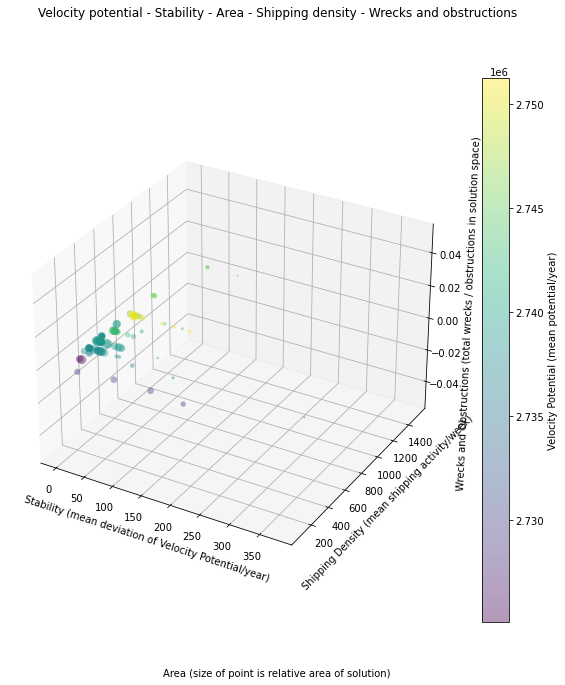

In [101]:
r = results[results['Rank'] == 0]
print(r.shape)

multidimensional(r)

### All solutions

(100, 17)


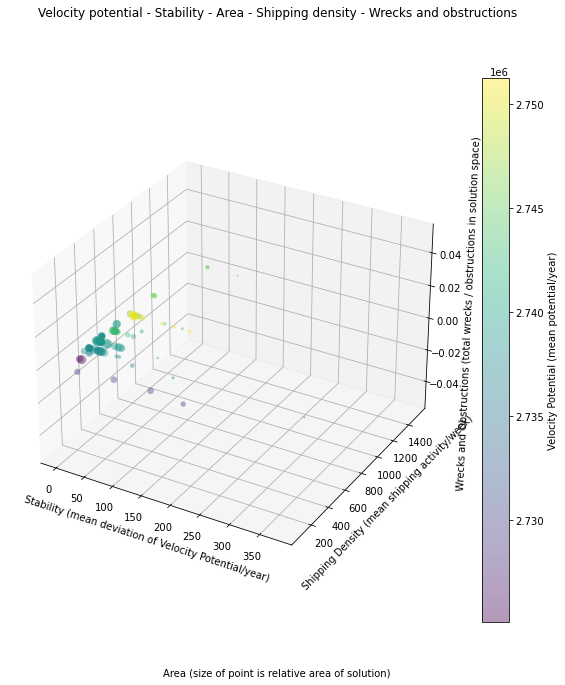

In [102]:
r = results
print(r.shape)

multidimensional(r)

## Solution visualisation

In [ ]:
file = 'UKHO ADMIRALTY bathymetry UK east coast.csv'
admiralty_df = pd.read_csv(file, sep=',')
admiralty_df = admiralty_df[admiralty_df['Depth'] > -40]

### All solutions

c:\Users\zacha\AppData\Local\Programs\Python\Python310\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


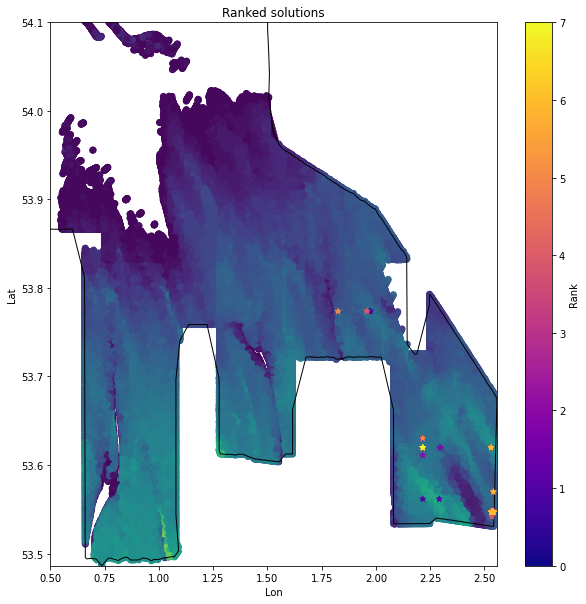

In [ ]:
fig = pl.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

ax.set_title("Ranked solutions")

# load depth scatter into plot and reuse
ax.scatter(admiralty_df["Lon"], admiralty_df["Lat"], c=admiralty_df["Depth"], cmap="viridis")

ax.set_xlabel("Lon")
ax.set_ylabel("Lat")

map_patch = PolygonPatch(map_polygon, fc="#999999", ec="#000000", fill=False)
ax.add_patch(map_patch)

map = ax.scatter(results['center_lon'], results['center_lat'], c=results['Rank'], cmap='plasma', marker="*")

# set axis limits to viable area
ax.set_xlim(lon_range)
ax.set_ylim(lat_range)

cbar = fig.colorbar(map, ax=ax)
cbar.set_label('Rank')

plt.show()


### Nondominated solutions vs. existing sites

In [ ]:
nondominated_solutions = results.loc[results['Rank'] == 0]

In [ ]:
file = 'UK east coast wind energy locations.csv'
df = pd.read_csv(file, sep=',')

points = pd.DataFrame(
    columns=[
        "center_lon",
        "center_lat",
        "q1_lon",
        "q1_lat",
        "q2_lon",
        "q2_lat",
        "q3_lon",
        "q3_lat",
        "q4_lon",
        "q4_lat"
    ]
)

ranges = []

for idx, row in df.iterrows():
    lon, lat, turbnum = row['LNG'], row['LAT'], row['TURBNUM']

    # square root turbnum to get number of turbines along lon / lat dimensions
    length_turbnum = np.sqrt(turbnum)

    # length of lon / lat dimensions from 586.74m radius / turbine in metres
    length = (length_turbnum * 586.74)

    # length of on side of quadrilateral
    quad_length = length / 2.0

    # area of shape in metres
    area = length * length

    # offset distance to corners = pythagorus to get hypotenuse
    diagonal = np.sqrt((quad_length*quad_length) + (quad_length*quad_length))

    # convert offset into lon / lat offset
    lat_offset = (1.0/1113200) * quad_length
    
    pos_lon_offset = (1.0/40075000) * quad_length * np.cos(lat+lat_offset) / 360.0
    neg_lon_offset = (1.0/40075000) * quad_length * np.cos(lat-lat_offset) / 360.0

    print((lat_offset*2, abs((pos_lon_offset + neg_lon_offset))))
    ranges.append((lat_offset*2, abs((pos_lon_offset + neg_lon_offset))))

    # calculate corners of quadrilateral from offsets
    q1 = (lon-neg_lon_offset, lat+lat_offset)
    q2 = (lon+pos_lon_offset, lat+lat_offset)
    q3 = (lon-neg_lon_offset, lat-lat_offset)
    q4 = (lon+pos_lon_offset, lat-lat_offset)

    points.loc[len(points.index)] = [lon, lat, *q1, *q2, *q3, *q4]


(0.008010847952089518, 5.950303590850086e-07)
(0.007071454501176214, 5.2525495282137e-07)
(0.00677040223069168, 4.4463432832268457e-07)
(0.006952598061405905, 5.164266173272261e-07)


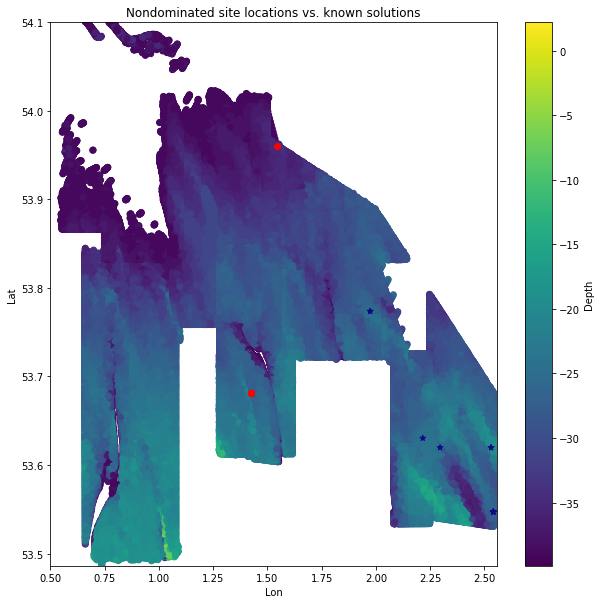

In [ ]:
# plot contrained to search space
fig = pl.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

ax.set_title("Nondominated site locations vs. known solutions")

map = ax.scatter(admiralty_df['Lon'], admiralty_df['Lat'], c=admiralty_df['Depth'], cmap='viridis')

ax.scatter(points['center_lon'], points['center_lat'], c="r", marker="o")

ax.scatter(nondominated_solutions['center_lon'], nondominated_solutions['center_lat'], c=nondominated_solutions['Rank'], cmap='plasma', marker="*")

ax.set_xlabel('Lon')
ax.set_ylabel('Lat')

# set axis limits to viable area
ax.set_xlim(lon_range)
ax.set_ylim(lat_range)

# add a legend indicating the depth of each point
cbar = fig.colorbar(map, ax=ax)
cbar.set_label('Depth')

pl.show()

c:\Users\zacha\AppData\Local\Programs\Python\Python310\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
c:\Users\zacha\AppData\Local\Programs\Python\Python310\lib\site-packages\shapely\affinity.py:109: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if origin == 'center':
c:\Users\zacha\AppData\Local\Programs\Python\Python310\lib\site-packages\shapely\affinity.py:113: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif origin == 'centroid':


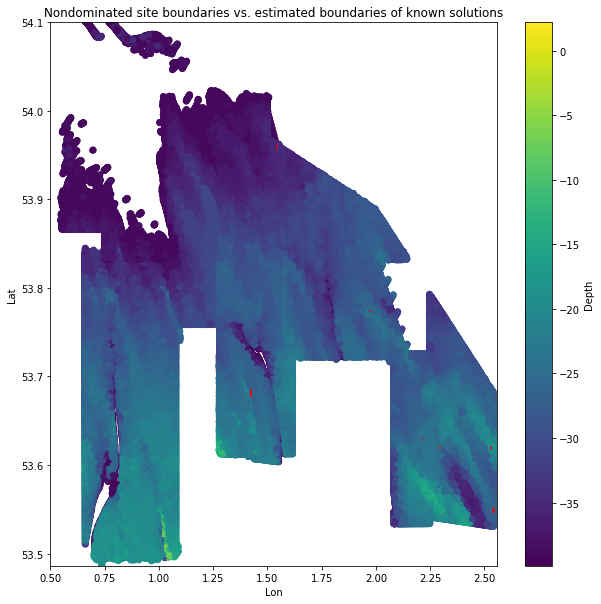

In [ ]:
# plot contrained to search space
fig = pl.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

ax.set_title("Nondominated site boundaries vs. estimated boundaries of known solutions")

map = ax.scatter(admiralty_df['Lon'], admiralty_df['Lat'], c=admiralty_df['Depth'], cmap='viridis')

# construct polygons from quads
for idx, row in points.iterrows():
    q1, q2, q3, q4 = (row["q1_lon"], row["q1_lat"]), (row["q2_lon"], row["q2_lat"]), (row["q3_lon"], row["q3_lat"]), (row["q4_lon"], row["q4_lat"])

    p = np.array([q1, q2, q3, q4])

    polygon = Polygon(p)

    patch = PolygonPatch(polygon, fc="#FF0000", ec="#FF0000", fill=True)
    ax.add_patch(patch)

for i in range(0, nondominated_solutions.shape[0]):
    x = nondominated_solutions.loc[i]

    x = x.to_numpy()

    # read solution into variables
    rotation = x[1]
    center = x[2:4]
    q1, q2, q3, q4 = x[4:6], x[6:8], x[8:10], x[10:12]

    # calculate corner coordinates from center and q offset
    # REVERSE XY from LAT LON to LON LAT
    q1_coord = [center[0] + q1[0], center[1] + q1[1]]
    q2_coord = [center[0] + q2[0], center[1] + q2[1]]
    q3_coord = [center[0] + q3[0], center[1] + q3[1]]
    q4_coord = [center[0] + q4[0], center[1] + q4[1]]

    # rotation corner coordinates by rotation angle
    p = np.array([q1_coord, q2_coord, q3_coord, q4_coord])

    polygon = Polygon(p)
    # rotate polygon by rotation angle about center coordinate
    polygon = affinity.rotate(polygon, rotation, origin=center)
    
    patch = PolygonPatch(polygon, fc="#FF0000", ec="#FF0000", fill=True)
    ax.add_patch(patch)

ax.set_xlabel('Lon')
ax.set_ylabel('Lat')

# set axis limits to viable area
ax.set_xlim(lon_range)
ax.set_ylim(lat_range)

# add a legend indicating the depth of each point
cbar = fig.colorbar(map, ax=ax)
cbar.set_label('Depth')

pl.show()